In [137]:
import json

import matplotlib.pyplot as plt
import pandas as pd

In [163]:
support_langs = ['en', 'de']
models_results_path_format = "model_outputs/2/%s.json"
models = ['gemma', 'llama31', 'gemma2B', 'aya']

In [164]:
def load_results(path):
    with open(path, 'r') as file:
        return json.load(file)

In [165]:
def preprocess_json(data):
    proper_data = []
    for lang in data:
        for r in data[lang]:
            r['lang'] = lang
            if 'quillbot_errors' not in r:
                r['quillbot_errors'] = None
            proper_data.append(r)
    return proper_data

In [166]:
original_dataset = preprocess_json(load_results("results.json"))
model_datasets = {model: preprocess_json(load_results(models_results_path_format % model)) for model in models}

In [167]:
def get_df(data):
    df = pd.DataFrame(data)

    df = df[df['lang'].isin(support_langs)]

    if 'path' in df.columns:
        df = df.drop(columns='path')

    df = df[(~df['id'].str.endswith("(1).txt"))]
    df = df[(~df['content'].str.isupper())]

    df['id'] = df['id'].apply(lambda x: x.replace(".txt", "").split("_")[1]).astype(int)

    df['word_count'] = df['content'].apply(lambda x: len(x.split()))
    df['score'] = 1 - (df['quillbot_errors'] / df['word_count'])

    df = df.sort_values(['id'])

    return df

In [168]:
original_df = get_df(original_dataset)
model_dfs = {model: get_df(data) for model, data in model_datasets.items()}

In [169]:
original_df.head()

,id,content,label,quillbot_errors,lang,word_count,score
9055,0,4 Die meisten Universitätsabschlüsse sind nich...,correct,1.0,de,17,0.941176
2071,0,13th June 2000,correct,0.0,en,3,1.000000
9070,1,Sie sind deswegen von geringem Wert.,correct,0.0,de,6,1.000000
1286,1,Dear Ms Helen Ryan,correct,1.0,en,4,0.750000
8852,2,Darum sage ich zu dieser Frage:,correct,0.0,de,6,1.000000


In [170]:
model_dfs['gemma'].head()

,id,label,content,quillbot_errors,lang,word_count,score
150,0,correct,13th June 2000 \n,0.0,en,3,1.0
8651,0,correct,Die meisten Universitätsabschlüsse sind nicht ...,NaN,de,16,NaN
287,1,correct,Dear Ms. Helen Ryan \n,0.0,en,4,1.0
7033,1,correct,Sie sind deshalb von geringem Wert. \n,NaN,de,6,NaN
318,2,correct,Competition Organizer \n,1.0,en,2,0.5


In [171]:
def plot_hist(d):
    plt.hist(d[d['label'] == 'correct']['score'], label='correct', alpha=0.5, bins=10)
    plt.hist(d[d['label'] == 'incorrect']['score'], label='incorrect', alpha=0.5, bins=10)
    plt.legend(loc='upper left')
    plt.show()

In [172]:
def extract_lang(df, l):
    return df[df['lang'] == l].set_index('id').sort_index()

In [173]:
def extract_lang_df(original_df, model_dfs, l):
    l_df: pd.DataFrame = extract_lang(original_df, l).drop(columns=['lang', 'quillbot_errors', 'word_count'])
    for model, df in model_dfs.items():
        l_df = l_df.join(extract_lang(df, l).drop(columns=['lang', 'quillbot_errors', 'word_count', 'label']),
                         rsuffix=f'_{model}')
    l_df = l_df.reindex(sorted(l_df.columns, reverse=True), axis=1)
    l_df.sort_values('score')
    return l_df

In [174]:
def show_metrics(df):
    print(f"Mean score on original dataset: {df['score'].mean():.3f}")
    print()
    r = {model: df[f'score_{model}'].mean() for model in models}
    for m, r in sorted(r.items(), key=lambda x: x[1], reverse=True):
        print(f"{m}: {r:.3f}")

## English

In [175]:
en_df = extract_lang_df(original_df, model_dfs, 'en')
en_df.head()

,score_llama31,score_gemma2B,score_gemma,score_aya,score,label,content_llama31,content_gemma2B,content_gemma,content_aya,content
id,,,,,,,,,,,
0,1.0,1.0,1.0,1.000000,1.00,correct,13 June 2000,"June 13, 2000 \n",13th June 2000 \n,"June 13, 2000",13th June 2000
1,1.0,1.0,1.0,1.000000,0.75,correct,Dear Ms. Helen Ryan,Dear Ms. Helen Ryan \n,Dear Ms. Helen Ryan \n,"Dear Ms. Ryan,",Dear Ms Helen Ryan
2,0.5,0.5,0.5,1.000000,1.00,correct,Competition Organizer,Competition Organizer \n,Competition Organizer \n,Competition Organiser,Competition Organiser
3,1.0,1.0,1.0,0.900000,0.90,correct,I am therefore writing to provide you with add...,I am writing to provide you with further infor...,I am therefore writing to provide you with fur...,I am therefore writing to give you my further ...,I am therefore writing to give you my further ...
4,1.0,1.0,1.0,0.933333,1.00,correct,"First of all, I am a student and would like to...","First of all, I am a student and would like to...","First of all, I am a student and would like to...","First of all, I am a student and I would like ...","First of all, I am a student and would like to..."


In [176]:
show_metrics(en_df)

Mean score on original dataset: 0.893

gemma2B: 0.984
gemma: 0.977
llama31: 0.968
aya: 0.955


In [177]:
print("correct only")
show_metrics(en_df[en_df['label'] == 'correct'])

correct only
Mean score on original dataset: 0.937

gemma2B: 0.988
gemma: 0.980
llama31: 0.977
aya: 0.969


In [178]:
print("incorrect only")
show_metrics(en_df[en_df['label'] == 'incorrect'])

incorrect only
Mean score on original dataset: 0.862

gemma2B: 0.982
gemma: 0.976
llama31: 0.961
aya: 0.946


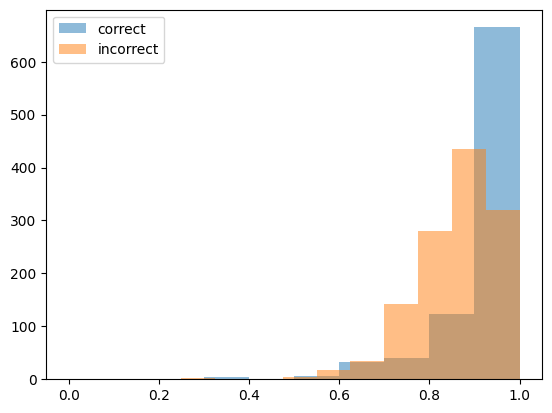

In [179]:
plot_hist(en_df)

In [180]:
en_df[(en_df['score'] != 1) & (en_df['label'] == 'correct')][['content', 'score']].sort_values('score')

,content,score
id,,
348,Ms MARIA AROZ,0.000000
155,"13th June, 2000",0.333333
149,"DEAR Helen Ryan,",0.333333
426,Dear Mr Robertson.,0.333333
117,"13th June, 2000",0.333333
...,...,...
304,"I've never been camping before, I guess I'm no...",0.961538
613,I am very proud that I won first prize in your...,0.962963
303,"With regard to the date of the trip, July woul...",0.964286


## German

In [181]:
de_df = extract_lang_df(original_df, model_dfs, 'de')
de_df.head()

,score_llama31,score_gemma2B,score_gemma,score_aya,score,label,content_llama31,content_gemma2B,content_gemma,content_aya,content
id,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,0.941176,correct,Die meisten Universitätsabschlüsse sind nicht ...,Die meisten universitären Abschlüsse sind nich...,Die meisten Universitätsabschlüsse sind nicht ...,Die meisten Universitätsabschlüsse sind nicht ...,4 Die meisten Universitätsabschlüsse sind nich...
1,NaN,NaN,NaN,NaN,1.000000,correct,Sie sind deshalb von geringem Wert.,Sie sind deshalb von geringem Wert. \n,Sie sind deshalb von geringem Wert. \n,Sie sind deswegen von geringem Wert.,Sie sind deswegen von geringem Wert.
2,NaN,NaN,NaN,NaN,1.000000,correct,Darüber sage ich zu dieser Frage:,Darum sage ich zu dieser Frage. \n,Darum sage ich dazu diese Frage: \n,Darauf möchte ich mit einer Gegenfrage antworten:,Darum sage ich zu dieser Frage:
3,NaN,NaN,NaN,NaN,1.000000,correct,"Ich verstehe nicht richtig, was du meinst. Bit...",Ja und Nein \n,Ja und Nein. \n,"""Ja und nein.""","\"" Ja und nein \""."
4,NaN,NaN,NaN,NaN,1.000000,correct,"Das ist tragisch, aber wahr.","Das ist traurig, aber wahr. \n","Das ist tragisch, aber wahr. \n","Das ist tragisch, aber wahr.","Das ist tragisch, aber wahr."


In [182]:
show_metrics(de_df)

Mean score on original dataset: 0.875

gemma: nan
llama31: nan
gemma2B: nan
aya: nan


In [183]:
print("correct only")
show_metrics(de_df[de_df['label'] == 'correct'])

correct only
Mean score on original dataset: 0.954

gemma: nan
llama31: nan
gemma2B: nan
aya: nan


In [184]:
print("incorrect only")
show_metrics(de_df[de_df['label'] == 'incorrect'])

incorrect only
Mean score on original dataset: 0.849

gemma: nan
llama31: nan
gemma2B: nan
aya: nan


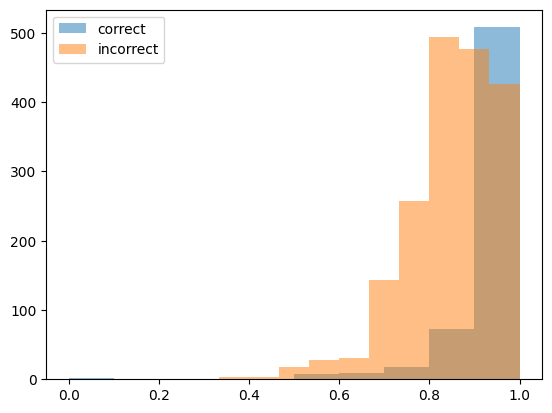

In [185]:
plot_hist(de_df)

In [186]:
de_df[(de_df['score'] != 1) & (de_df['label'] == 'correct')][['content', 'score']].sort_values('score')

,content,score
id,,
493,gekauft.,0.000000
412,online.,0.000000
618,Hoffentlich bis bald Katharina 27.02.2012,0.400000
531,Viele Grüße.,0.500000
490,war schön.,0.500000
...,...,...
105,Dieses Phänomen ist ein wichtiges Problem in a...,0.960000
360,"In diesem Text „Ist es sinnvoll, auch im Ausla...",0.960000
60,"Ich denke besonders an die vielen Kinder, Taus...",0.961538
